In [1]:
import pickle
import os
import pandas as pd

output_dir = "outputs"
splitted_docs = pickle.load(open(os.path.join(output_dir, "split_docs.pkl"), 'rb'))
qa_df = pd.read_json(os.path.join(output_dir, "qa.json"), lines=True)

In [3]:
from langchain.embeddings import init_embeddings
from langchain.chat_models import init_chat_model
from langchain_chroma import Chroma
import dotenv
import os
dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("API_KEY", "")
os.environ["OPENAI_BASE_URL"] = os.getenv("BASE_URL", "")
llm = init_chat_model(
    model='openai:gpt-4o-mini',
    temperature = 0.8,
    top_p = 0.85
)
embeddings = init_embeddings(
    model="openai:text-embedding-3-small",
)

vector_db = Chroma.from_documents(
    documents=splitted_docs,
    persist_directory= os.path.join(output_dir, 'chromadb_v1'),
    embedding=embeddings
)

In [16]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

hype_prompt = PromptTemplate(
    input_variables=['question'],
    template = """你是一位精通财经的专业分析师，请基于用户提问，回答问题, 答案尽量精简，在30个字左右。
问题：{question}
请回答：
"""
)
hype_parser = StrOutputParser()
retriever = vector_db.as_retriever(search_kwargs={'k' : 8})

chain = (
    hype_prompt
    | llm
    | hype_parser
    | retriever
)

In [17]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
from tqdm.auto import tqdm
import pandas as pd
hit_rate_data = []
def hype(row):
    question = row['question']
    true_uuid = row['uuid']
    retries = 3
    delay = 1
    for i in range(retries):
        try:
            docs = chain.invoke({'question': question})
            uuids = [doc.metadata['uuid'] for doc in docs]
            hits = []
            for k in range(1, 9):
                hits.append({
                    'question': question,
                    'top_k': k,
                    'hit': int(true_uuid in uuids[:k])
                })
            return hits
        except Exception as exc:
            if i < retries - 1:
                time.sleep(delay)
                delay *= 2
            else:
                raise exc
    return []

with ThreadPoolExecutor(max_workers=16) as excecutor:
    futures = [excecutor.submit(hype, row) for idx, row in qa_df.iterrows()]
    for future in tqdm(as_completed(futures), total=len(qa_df)):
        hit_rate_data.extend(future.result())

hit_rate_df = pd.DataFrame(hit_rate_data)

100%|██████████| 401/401 [02:10<00:00,  3.06it/s]


In [19]:
hyde_hits = hit_rate_df.groupby('top_k')['hit'].mean().reset_index()
data = [
    {'top_k': 1, 'hit': 0.405},
    {'top_k': 2, 'hit': 0.580},
    {'top_k': 3, 'hit': 0.665},
    {'top_k': 4, 'hit': 0.715},
    {'top_k': 5, 'hit': 0.755},
    {'top_k': 6, 'hit': 0.795},
    {'top_k': 7, 'hit': 0.840},
    {'top_k': 8, 'hit': 0.855}
]
base = pd.DataFrame(data)
hyde_hits['dataset'] = 'hyde'
base['dataset'] = 'baseline'
concat_df = pd.concat([hyde_hits, base])
print(concat_df)

   top_k       hit   dataset
0      1  0.526185      hyde
1      2  0.526185      hyde
2      3  0.665835      hyde
3      4  0.665835      hyde
4      5  0.760599      hyde
5      6  0.760599      hyde
6      7  0.790524      hyde
7      8  0.790524      hyde
0      1  0.405000  baseline
1      2  0.580000  baseline
2      3  0.665000  baseline
3      4  0.715000  baseline
4      5  0.755000  baseline
5      6  0.795000  baseline
6      7  0.840000  baseline
7      8  0.855000  baseline


<Axes: xlabel='top_k', ylabel='hit'>

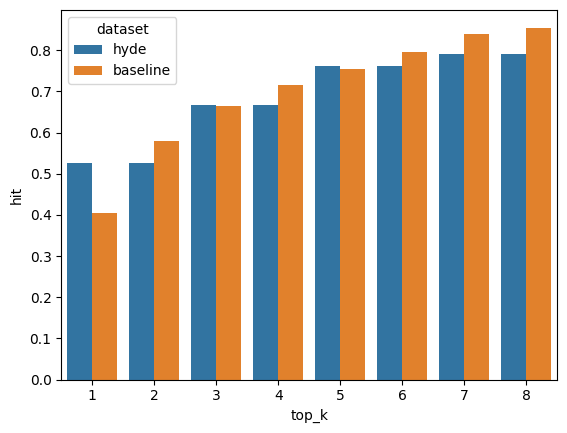

In [21]:
import seaborn as sns

sns.barplot(data=concat_df, x='top_k', y='hit', hue='dataset')